### In this notebook we address state space models for a plasma experiment
The HITSI-U experiment relies on a set of four injectors, each with three circuit variables. The model for the circuit is the following state space model:
$$\dot{\mathbf x} = \mathbf A \mathbf x + \mathbf B \mathbf u,$$
$$\dot{\mathbf y} = \mathbf C \mathbf x,$$
with the matrices defined below. 

In [1]:
# import libraries
import numpy as np
import pysindy as ps
from matplotlib import pyplot as plt
from scipy.signal import StateSpace, lsim, dlsim
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error

In [8]:
# Define the state space model 

Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 #H
L2 = 2.0462e-6 #H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
NoisePower = 0.1
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1/((L2-Mw)*( (L2 ** 2) - (4*M ** 2)  +  2*L2*Mw +  (Mw ** 2) ))

x3a =  (-L2 ** 2)*R2 + (2*M ** 2)*R2-L2*Mw*R2
x3b = (-L2 ** 2) + (2*M ** 2)-L2*Mw
x3c = (L2 ** 2)*R2-(2*M ** 2)*R2 + L2*Mw*R2 + (L2 ** 2)*R3-(2*M ** 2)*R3 + L2*Mw*R3
x3d = L2*M*R2 - M*Mw*R2
x3e = L2*M-M*Mw
x3f = -L2*M*R2 + M*Mw*R2-L2*M*R3 + M*Mw*R3
x3g = L2*M*R2-M*Mw*R2
x3h = L2*M-M*Mw
x3i = -L2*M*R2 + M*Mw*R2-L2*M*R3 + M*Mw*R3
x3j = -2*(M ** 2)*R2 + L2*Mw*R2 + (Mw ** 2)*R2
x3k = -2*(M ** 2) + L2*Mw + Mw ** 2
x3l = 2*(M ** 2)*R2-L2*Mw*R2-(Mw ** 2)*R2 + 2*R3*(M ** 2)-L2*Mw*R3-R3*Mw ** 2

# Entries for x6 in A matrix
x6a = -L2*M*R2 + M*Mw*R2
x6b = -L2*M + M*Mw
x6c = L2*M*R2-M*Mw*R2 + L2*M*R3-M*Mw*R3
x6d = R2*(L2 ** 2)-2*R2*(M ** 2) + L2*Mw*R2
x6e = (L2 ** 2)-2*(M ** 2) + L2*Mw
x6f = -R2*(L2 ** 2) + 2*R2*(M ** 2)-L2*Mw*R2-R3*(L2 ** 2) + 2*R3*(M ** 2)-L2*Mw*R3
x6g = 2*R2*(M ** 2)-L2*Mw*R2-R2*(Mw ** 2)
x6h = 2*(M ** 2)-L2*Mw-(Mw ** 2)
x6i = -2*R2*(M ** 2) + L2*Mw*R2 + R2*(Mw ** 2)-2*R3*(M ** 2) + L2*Mw*R3 + R3*(Mw ** 2)
x6j = -L2*M*R2 + M*Mw*R2
x6k = -L2*M + M*Mw
x6l = L2*M*R2-M*Mw*R2 + L2*M*R3-M*Mw*R3
##Entries for x9 in A matrix
x9a = -L2*M*R2  +  M*Mw*R2
x9b = -L2* M  +  M* Mw
x9c = L2* M* R2 - M* Mw* R2 *  +  L2* M *R3  - M* Mw* R3
x9d = 2* (M ** 2) *R2 - L2*Mw* R2 - (Mw ** 2) *R2
x9e = 2 *(M ** 2) - L2* Mw - (Mw ** 2)
x9f = -2* (M ** 2)* R2 +  L2 *Mw *R2  +  (Mw ** 2) *R2 - 2* (M ** 2) *R3  +  L2 *Mw* R3  +  (Mw ** 2) *R3
x9g =(L2 ** 2) *R2 - 2* (M ** 2) *R2  +  L2 *Mw *R2
x9h = (L2 ** 2) - 2* (M ** 2)  +  L2 *Mw
x9i = -(L2 ** 2) *R2  +  2* (M ** 2)* R2 - L2 *Mw *R2 - (L2 ** 2) *R3  +  2* (M ** 2)* R3- L2 *Mw *R3
x9j = -L2 *M *R2  +  M*Mw*R2
x9k = -L2 *M  +  M *Mw 
x9l = L2*M*R2 - M* Mw *R2  +  L2 *M *R3 - M* Mw *R3

#Entries for x12 in A matrix
x12a = -2* (M ** 2) *R2 +  L2* Mw* R2  + (Mw ** 2)* R2
x12b = -2 *(M ** 2)  +  L2 *Mw  +  (Mw ** 2)
x12c = 2 *(M ** 2) *R2 - L2 *Mw *R2 - (Mw ** 2) *R2  +  2 *(M ** 2) *R3 - L2 *Mw *R3 - (Mw ** 2) *R3
x12d = L2 *M *R2 - M *Mw *R2
x12e = L2 *M - M *Mw
x12f = -L2 *M *R2  +  M *Mw *R2 - L2 *M *R3  +  M *Mw* R3
x12g = L2 *M *R2 - M *Mw *R2
x12h = L2 *M - M *Mw
x12i = -L2 *M *R2  +  M *Mw *R2 - L2 *M *R3  +  M *Mw *R3
x12j = (-L2 ** 2) *R2  +  2 *(M ** 2) *R2 - L2 *Mw *R2
x12k = (-L2 ** 2)  +  2 *(M ** 2) - L2* Mw
x12l = (L2 ** 2) *R2 - 2 *(M ** 2) *R2  +  L2 *Mw *R2  +  (L2 ** 2) *R3 - 2*(M ** 2)* R3  +  L2 *Mw *R3

A = np.array([[((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1/Cap, 0, -1/Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1*x3a, -scalar1*x3b,-scalar1*x3c, -scalar1*x3d, 
      -scalar1*x3e, -scalar1*x3f, -scalar1*x3g, -scalar1*x3h, 
      -scalar1*x3i, -scalar1*x3j, -scalar1*x3k, -scalar1*x3l],
     [0, 0, 0, ((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1/Cap, 0, -1/Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1*x6a, scalar1*x6b, scalar1*x6c, scalar1*x6d, 
      scalar1*x6e, scalar1*x6f, scalar1*x6g, scalar1*x6h, 
      scalar1*x6i, scalar1*x6j, scalar1*x6k, scalar1*x6l],
     [0, 0, 0, 0, 0, 0, ((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1/Cap, 0, -1/Cap, 0, 0, 0], 
     [scalar1*x9a, scalar1*x9b, scalar1*x9c, scalar1*x9d, 
      scalar1*x9e, scalar1*x9f, scalar1*x9g, scalar1*x9h, 
      scalar1*x9i, scalar1*x9j, scalar1*x9k, scalar1*x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1/Cap, 0, -1/Cap], 
     [-scalar1*x12a, -scalar1*x12b, -scalar1*x12c, -scalar1*x12d,
      -scalar1*x12e, -scalar1*x12f, -scalar1*x12g, -scalar1*x12h, 
      -scalar1*x12i, -scalar1*x12j, -scalar1*x12k, -scalar1*x12l]]
)

B = np.array([[1/L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1/L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1/L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1/L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array([[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) # Notice all negative eigenvalues!

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626724 +137273.04651637j -6044.9626724 -137273.04651637j
 -6044.96265483+137273.04655165j -6044.96265483-137273.04655165j
 -2052.57854051     +0.j         -2915.80444687     +0.j
 -2915.80453607     +0.j         -2983.64806906     +0.j        ]


In [3]:
# continuous time system
sysc = StateSpace(A, B, C, D) 

# discrete time system
# sysd = sysc.to_discrete(dT)

### Load in the voltage control inputs
These are square waves at some pre-defined injector frequency.

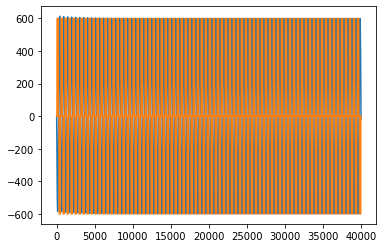

In [4]:
# Ad = sysd.A
# Bd = sysd.B
# Cd = sysd.C
# Dd = sysd.D

# G = np.eye(3)
# H = np.zeros((3, 3))

# Q = .001  # diag(.001*ones(1,size(A, 1))) % disturbance covariance
# R = np.diag(10 * np.ones(B.shape[1]))  # Noise covariance
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)  #(0:SampleTime:RunTime)

##
data = loadmat('data/voltages.mat')
data = loadmat('data/voltages.mat')

# print(data)
voltage1 = data['voltage']  # / 1000
voltage2 = data['newVoltageShift1']  # / 1000
voltage3 = data['newVoltageShift2']  # / 1000
voltage4 = data['newVoltageShift3']  # / 1000
plt.plot(voltage1)
plt.plot(voltage3)
plt.show()

In [5]:
tout, yout, xout = lsim(
    sysc, 
    np.hstack([voltage1, voltage2, voltage3, voltage4]), 
    time
)

rmse = mean_squared_error(xout[:, 1], np.zeros(xout[:, 1].shape), squared=False)
xout = xout + np.random.normal(0, rmse / 100.0 * 2, xout.shape)

# syskf = StateSpace(
#     Ad-L@Cd, 
#     np.hstack((Bd, L)), 
#     np.eye(12), 
#     0*np.hstack((Bd, L)), 
#     dt=dT
# )
# tkout, ykout, xkout = dlsim(
#     syskf, 
#     np.hstack([voltage, voltage, voltage, voltage, yout]), 
#     time
# )

# Could consider rescaling units here
xout = xout
yout = yout
tout = tout 
dt = tout[1] - tout[0]

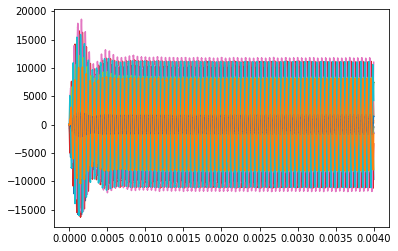

In [6]:
for i in range(12):
    plt.plot(tout, xout[:, i])

In [19]:
# Okay time to use PySINDy on this 12D system of ODEs
u = np.hstack([voltage1, voltage2, voltage3, voltage4])
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)

# Discover dx/dt = Ax + Bu 

# optimizer_stable = ps.STLSQ(threshold=1e2, verbose=True)

### Below: special optimizer if need to make sure linear matrix is stable! ###

optimizer_stable = ps.ConstrainedSR3(
    threshold=0,
    thresholder='l1',
    nu=1,
    max_iter=10,
    tol=1e-5,
    verbose=True,
)

model = ps.SINDy(feature_library=sindy_library, 
                 optimizer=optimizer_stable)
model.fit(xout, t=tout, u=u)
# model.print()

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 1.1453e+22 ... 0.0000e+00 ... 0.0000e+00 ... 1.1453e+22


AttributeError: 'ConstrainedSR3' object has no attribute 'constraint_lhs'

AttributeError: 'ConstrainedSR3' object has no attribute 'constraint_lhs'

### Without noise, can match A and B matrices quite well

In [10]:
Xi = model.coefficients()
r = Xi.shape[0]
B_SINDy = Xi[:r, r:]
A_SINDy = Xi[:r, :r]
print(B_SINDy, B)
print(A_SINDy, A)

[[ 1.42167180e+06 -4.70568864e+04  8.69390725e+03 -4.32847409e+04]
 [ 7.85997915e+03  5.91916008e+03  2.46746245e+03  2.18411452e+03]
 [-9.14374408e+04  1.46823014e+04  3.72348833e+03  9.66760063e+03]
 [-5.84178295e+04  9.75205001e+05  2.02874010e+03 -2.35615612e+05]
 [ 7.39858380e+03  8.15206326e+03  7.73068427e+02  1.06567442e+04]
 [ 4.25617301e+04  1.74506969e+04 -2.59207693e+03  1.47829499e+04]
 [-7.97364842e+04  4.76275447e+04  1.22190231e+06  3.83362176e+04]
 [-3.11250956e+03  2.25116882e+04  1.92184625e+03  2.21487228e+04]
 [ 6.44113545e+04 -2.39668588e+03 -6.93708707e+03  1.86897966e+03]
 [ 8.54962671e+04 -1.80293281e+05 -2.57375772e+03  1.02319136e+06]
 [-2.38810209e+03  3.18547555e+04  5.88368338e+02  3.25788215e+04]
 [-5.38607692e+04  8.59380961e+03  1.05589945e+03  1.30835039e+04]] [[1247800.75117605       0.               0.               0.        ]
 [      0.               0.               0.               0.        ]
 [      0.               0.               0.         

In [11]:
# Condition number is quite good actually!
np.linalg.cond(optimizer_stable.Theta_)

783.7396983470226

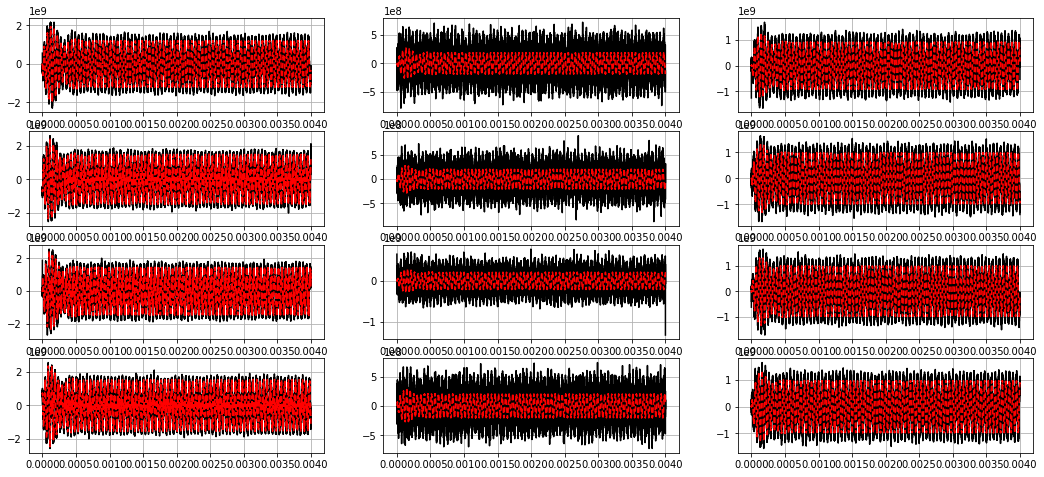

In [16]:
ydot_true = model.differentiate(xout, t=tout)
ydot_pred = model.predict(xout, u=u)
plt.figure(figsize=(18, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.grid(True)
    plt.plot(tout, ydot_true[:, i], 'k')
    plt.plot(tout, ydot_pred[:, i], 'r--')

### Check if the A matrix is negative definite!
If not all the eigenvalues are negative, model is unstable. If so, optimize with the StableLinearOptimizer until the eigenvalues are pushed to be all negative. 

In [13]:
# print(np.sort(np.linalg.eigvals(optimizer_stable.coef_history[-1, :12, :12])))
# print(np.sort(np.linalg.eigvals(optimizer_stable.coef_history[0, :12, :12])))
Xi = model.coefficients()
print(np.sort(np.linalg.eigvals(Xi[:12, :12])))

[-12630.12739189 -53834.89529227j -12630.12739189 +53834.89529227j
  -7307.24149336-137721.99393894j  -7307.24149336+137721.99393894j
  -3374.83650721     +0.j          -3000.77105404-114794.98334505j
  -3000.77105404+114794.98334505j  -1602.83388254     +0.j
  -1234.29605664 -43803.45030017j  -1234.29605664 +43803.45030017j
   5967.88473481 -10825.16775819j   5967.88473481 +10825.16775819j]


### Now try resimulating the training data from some initial condition on the data
This is a 12D system and the time base is VERY well-sampled so integration might take a while!

In [ ]:
x0_new = np.random.rand(12) - 0.5
tout, yout, xout = lsim(
    sysc, 
    np.hstack([voltage1, voltage2, voltage3, voltage4]), 
    time,
    x0=x0_new,
)
x_pred = model.simulate(x0_new, 
                        t=tout[t_start:int(len(tout) // 2)], 
                        u=u[t_start:int(len(tout) // 2), :])

In [ ]:
for i in range(12):
    plt.figure()
    plt.plot(xout[t_start:, i], 'k')
    plt.plot(x_pred[t_start:, i], 'r')